In [2]:
# Import relevant modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from netCDF4 import Dataset
from datetime import date, timedelta
import time
from scipy.interpolate import interp2d

In [3]:
# Read netCDF data 
ds = Dataset('slp.mon.mean-2.nc')

In [4]:
# Print data variables
print(ds.variables.keys())

dict_keys(['lat', 'lon', 'time', 'slp'])


In [5]:
# Get shape of time variable - i.e. number of time data points
print(ds.variables['time'].shape)

(894,)


In [6]:
# Print metadata of sea level pressure variable
print(ds.variables['slp'])

<class 'netCDF4._netCDF4.Variable'>
float32 slp(time, lat, lon)
    long_name: Sea Level Pressure
    valid_range: [ 870. 1150.]
    units: millibars
    add_offset: 0.0
    scale_factor: 1.0
    missing_value: -9.96921e+36
    precision: 1
    least_significant_digit: 1
    var_desc: Sea Level Pressure
    level_desc: Sea Level
    statistic: Mean
    parent_stat: Other
    dataset: NCEP Reanalysis Derived Products
    actual_range: [ 955.56085 1082.5582 ]
unlimited dimensions: time
current shape = (894, 73, 144)
filling on, default _FillValue of 9.969209968386869e+36 used


In [7]:
# Print metadata of longitude variable
print(ds.variables['lon'])

<class 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
    units: degrees_east
    long_name: Longitude
    actual_range: [  0.  357.5]
    standard_name: longitude
    axis: X
unlimited dimensions: 
current shape = (144,)
filling on, default _FillValue of 9.969209968386869e+36 used


In [8]:
# Print metadata of latitude variable
print(ds.variables['lat'])

<class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    units: degrees_north
    actual_range: [ 90. -90.]
    long_name: Latitude
    standard_name: latitude
    axis: Y
unlimited dimensions: 
current shape = (73,)
filling on, default _FillValue of 9.969209968386869e+36 used


In [9]:
# Find index that gives final desired time (01/12/2021)
start_time = date(1800,1,1) # Start date
t_diff = np.ma.getdata(ds.variables['time'])[887] # Get time difference from data
new_date = start_time + timedelta(hours=t_diff) # Add time differece to start date
print(new_date) # Print final dte

2021-12-01


In [10]:
# Get latitudes in data
lats = np.ma.getdata(ds.variables['lat'][:])
# Get longitudes in data
lons = np.ma.getdata(ds.variables['lon'][:])

In [11]:
# Check latitudes 
print(lats)
# Check longitudes
print(lons)

[ 90.   87.5  85.   82.5  80.   77.5  75.   72.5  70.   67.5  65.   62.5
  60.   57.5  55.   52.5  50.   47.5  45.   42.5  40.   37.5  35.   32.5
  30.   27.5  25.   22.5  20.   17.5  15.   12.5  10.    7.5   5.    2.5
   0.   -2.5  -5.   -7.5 -10.  -12.5 -15.  -17.5 -20.  -22.5 -25.  -27.5
 -30.  -32.5 -35.  -37.5 -40.  -42.5 -45.  -47.5 -50.  -52.5 -55.  -57.5
 -60.  -62.5 -65.  -67.5 -70.  -72.5 -75.  -77.5 -80.  -82.5 -85.  -87.5
 -90. ]
[  0.    2.5   5.    7.5  10.   12.5  15.   17.5  20.   22.5  25.   27.5
  30.   32.5  35.   37.5  40.   42.5  45.   47.5  50.   52.5  55.   57.5
  60.   62.5  65.   67.5  70.   72.5  75.   77.5  80.   82.5  85.   87.5
  90.   92.5  95.   97.5 100.  102.5 105.  107.5 110.  112.5 115.  117.5
 120.  122.5 125.  127.5 130.  132.5 135.  137.5 140.  142.5 145.  147.5
 150.  152.5 155.  157.5 160.  162.5 165.  167.5 170.  172.5 175.  177.5
 180.  182.5 185.  187.5 190.  192.5 195.  197.5 200.  202.5 205.  207.5
 210.  212.5 215.  217.5 220.  222.5 225.  

In [12]:
# Define desired latitudes
lats_full = [y/10 for y in range(895,-905,-10)]
# Define desired longitudes
lons_full = [x/10 for x in range(5,3600,10)]

In [13]:
# Sea level pressure data in on 2.5x2.5 degree resolution and
# needs interpolating to 1x1degree resolution in 2 dimensions

start_idx=504 # Starting index
end_idx=887 # Final index

# Loop over time index
for t in range(start_idx,end_idx+1):
    # Get difference between reference time and indexed time
    t_diff = np.ma.getdata(ds.variables['time'])[t]
    # Get indexed date
    new_date = start_time + timedelta(hours=t_diff)
    # Print date
    print(new_date, end=' ')
    # Produce dataframe/array of sea level pressure data
    raw_data = pd.DataFrame(data = ds.variables['slp'][t,:,:], index=lats, columns=lons)
    # Create interpolation using Scipy interp2d method
    slp_interp = interp2d(lons, lats[::-1],raw_data.values, kind='linear')
    # Produce new data using inerpolation across desired coordinates
    complete_data = slp_interp(lons_full, lats_full)
    # Switch halves of data to produce desired map projection (-180 to 180)
    complete_data = np.concatenate((complete_data[:,180:],complete_data[:,:180]),axis=1)
    # If loop is at start index initialise 3D array to store sea level pressure data
    if t == start_idx:
        slp_all = complete_data
    # Else append sea level pressure data to 3D array
    else:
        slp_slice = complete_data
        slp_all = np.dstack((slp_all,slp_slice))
    # Print data shape as check
    print(slp_all.shape)

1990-01-01 (180, 360)
1990-02-01 (180, 360, 2)
1990-03-01 (180, 360, 3)
1990-04-01 (180, 360, 4)
1990-05-01 (180, 360, 5)
1990-06-01 (180, 360, 6)
1990-07-01 (180, 360, 7)
1990-08-01 (180, 360, 8)
1990-09-01 (180, 360, 9)
1990-10-01 (180, 360, 10)
1990-11-01 (180, 360, 11)
1990-12-01 (180, 360, 12)
1991-01-01 (180, 360, 13)
1991-02-01 (180, 360, 14)
1991-03-01 (180, 360, 15)
1991-04-01 (180, 360, 16)
1991-05-01 (180, 360, 17)
1991-06-01 (180, 360, 18)
1991-07-01 (180, 360, 19)
1991-08-01 (180, 360, 20)
1991-09-01 (180, 360, 21)
1991-10-01 (180, 360, 22)
1991-11-01 (180, 360, 23)
1991-12-01 (180, 360, 24)
1992-01-01 (180, 360, 25)
1992-02-01 (180, 360, 26)
1992-03-01 (180, 360, 27)
1992-04-01 (180, 360, 28)
1992-05-01 (180, 360, 29)
1992-06-01 (180, 360, 30)
1992-07-01 (180, 360, 31)
1992-08-01 (180, 360, 32)
1992-09-01 (180, 360, 33)
1992-10-01 (180, 360, 34)
1992-11-01 (180, 360, 35)
1992-12-01 (180, 360, 36)
1993-01-01 (180, 360, 37)
1993-02-01 (180, 360, 38)
1993-03-01 (180, 360, 39

KeyboardInterrupt: 

In [ ]:
# Flatten data for saving to CSV
for d in range(0, slp_all.shape[2]):
    if d == 0:
        slp_LR_flat = slp_all[:,:,d]
    else:
        slp_LR_flat = np.concatenate((slp_LR_flat, slp_all[:,:,d]), axis=0) 
        
# Save data to CSV
np.savetxt('slp_LR_flat.csv',slp_LR_flat, delimiter=',')

<AxesSubplot:>

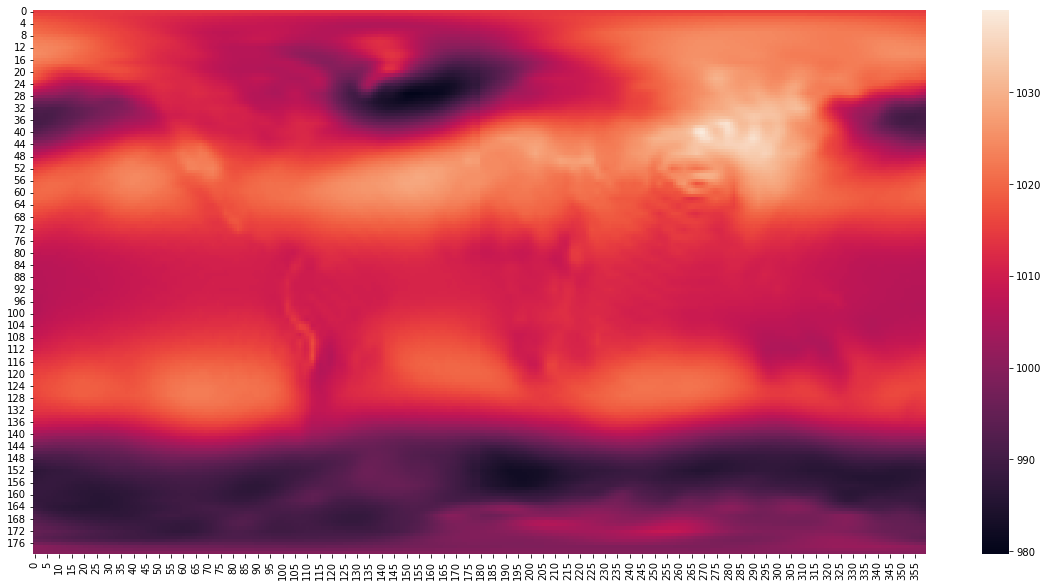

In [14]:
# Plot a selection of data as a check
plt.figure(figsize=(20,10))
sns.heatmap(slp_all[:,:,0])

<AxesSubplot:>

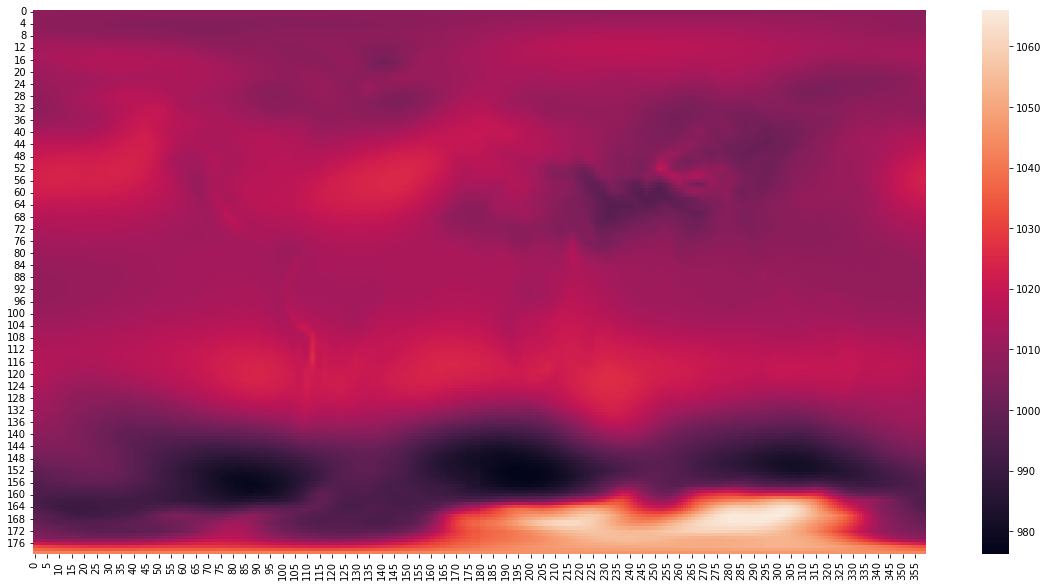

In [16]:
# Plot a selection of data as a check
plt.figure(figsize=(20,10))
sns.heatmap(slp_all[:,:,6])